#Install lightning

In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 19.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

#Importing packages

In [2]:
import torch
import torchmetrics
from torch import nn
from torchvision.datasets import Imagenette, CIFAR10
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning import Callback

#Dataset download and transformation (Non Regularized Transformation)

In [3]:
#Code referenced from given file on github
train_transforms = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

test_transforms = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px", download=True, transform=train_transforms)

# Use 10% of the training set for validation
train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=seed)
val_dataset.dataset.transform = test_transforms

# Use DataLoader to load the dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=8, shuffle=False)

# Configure the test dataset
test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px", download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, num_workers=8, shuffle=False)

early_stop_callback = EarlyStopping(monitor="val_loss",
                                    mode="min",
                                    patience=5)
# Configure Checkpoints
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min"
)

100%|██████████| 99003388/99003388 [00:02<00:00, 36285762.10it/s]


Extracting data/imagenette/train/imagenette2-160.tgz to data/imagenette/train/


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


100%|██████████| 99003388/99003388 [00:02<00:00, 39779204.87it/s]


Extracting data/imagenette/test/imagenette2-160.tgz to data/imagenette/test/


#CNN

In [4]:
class cnn(L.LightningModule):
  def __init__(self, n = 10):
    super().__init__()
    self.nw = nn.Sequential(
        nn.Conv2d(3, 32, padding = 1, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, padding = 1, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.flat = nn.Flatten()
    self.lay = nn.Sequential(
        nn.Linear(64 * 7 * 7, 256),
        nn.ReLU(),

    )
    self.lay_con = nn.Linear(256, n)
    self.acc = torchmetrics.Accuracy(task = 'multiclass', num_classes= n)

  def forward(self, a):
    a = self.nw(a)
    a = self.flat(a)
    a = self.lay(a)
    a = self.lay_con(a)
    return a

  def training_step(self, bth, id):
    a, b = bth
    y = self(a)
    l = F.cross_entropy(y, b)
    self.log('train_loss', l, on_step=True, on_epoch=True)
    return l

  def validation_step(self, bth, id):
    a, b = bth
    y = self(a)
    l = F.cross_entropy(y, b)
    self.acc(y, b)
    self.log('val_accuracy', self.acc)
    self.log('val_loss', l, on_step=True, on_epoch=True)

  def test_step(self, bth, id):
    a, b = bth
    y = self(a)
    l = F.cross_entropy(y, b)
    self.acc(y, b)
    self.log('test_accuracy', self.acc)
    self.log('test_loss', l, on_step=True, on_epoch=True)

  def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer



##Training

In [5]:
m1 = cnn()
t = L.Trainer(callbacks = [early_stop_callback, checkpoint_callback])
t.fit(model = m1, train_dataloaders = train_loader, val_dataloaders = val_loader)
t.callback_metrics

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type               | Params
-----------------------------------------------
0 | nw      | Sequential         | 19.4 K
1 | flat    | Flatten            | 0     


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

{'train_loss': tensor(0.4919),
 'train_loss_step': tensor(0.5048),
 'val_accuracy': tensor(0.6357),
 'val_loss': tensor(1.2135),
 'val_loss_epoch': tensor(1.2135),
 'train_loss_epoch': tensor(0.4919)}

##Testing

In [6]:
t.test(model=m1, dataloaders=test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6211465001106262     │
│      test_loss_epoch      │    1.2943201065063477     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.6211465001106262, 'test_loss_epoch': 1.2943201065063477}]

#All Convolutional Net

In [7]:
class acnn(L.LightningModule):
  def __init__(self, n = 10):
    super().__init__()
    self.feat = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(64, 64, kernel_size = 3, stride = 2, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(128, n, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace = True),
        nn.AdaptiveAvgPool2d((1,1))
        )
    self.acc = torchmetrics.Accuracy(task = 'multiclass', num_classes = n)

  def forward(self, a):
    a = self.feat(a)
    a = a.view(a.size(0), -1)
    return a

  def training_step(self, bth, id):
    a, b = bth
    y = self(a)
    l = F.cross_entropy(y, b)
    self.log('train_loss', l, on_step=True, on_epoch=True)
    return l

  def validation_step(self, bth, id):
    a, b = bth
    y = self(a)
    l = F.cross_entropy(y, b)
    self.acc(y, b)
    self.log('val_accuracy', self.acc)
    self.log('val_loss', l, on_step=True, on_epoch=True)

  def test_step(self, bth, id):
    a, b = bth
    y = self(a)
    l = F.cross_entropy(y, b)
    self.acc(y, b)
    self.log('test_accuracy', self.acc)
    self.log('test_loss', l, on_step=True, on_epoch=True)

  def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


##Training

In [8]:
m2 = acnn()
t = L.Trainer(callbacks = [early_stop_callback, checkpoint_callback])
t.fit(model = m2, train_dataloaders = train_loader, val_dataloaders = val_loader)
t.callback_metrics

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /content/lightning_logs/version_0/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

{'train_loss': tensor(2.2158),
 'train_loss_step': tensor(2.1231),
 'val_accuracy': tensor(0.2165),
 'val_loss': tensor(2.1609),
 'val_loss_epoch': tensor(2.1609),
 'train_loss_epoch': tensor(2.2158)}

##Testing

In [9]:
t.test(model = m2, dataloaders=test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.17401273548603058    │
│      test_loss_epoch      │     2.197969913482666     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.17401273548603058, 'test_loss_epoch': 2.197969913482666}]

#Regularization

In [10]:
train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
            transforms.RandomResizedCrop((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
test_transforms = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px", download=False, transform=train_transforms)

# Use 10% of the training set for validation
train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=seed)
val_dataset.dataset.transform = test_transforms

# Use DataLoader to load the dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=8, shuffle=False)

# Configure the test dataset
test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px", download=False, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, num_workers=8, shuffle=False)

early_stop_callback = EarlyStopping(monitor="val_loss",
                                    mode="min",
                                    patience=5)
# Configure Checkpoints
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min"
)

##CNN (Regularized)

In [11]:
mr = cnn()
t = L.Trainer(callbacks=[early_stop_callback, checkpoint_callback])
t.fit(model=mr, train_dataloaders=train_loader,  val_dataloaders=val_loader)
t.callback_metrics

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type               | Params
-----------------------------------------------
0 | nw      | Sequential         | 19.4 K
1 | flat    | Flatten            | 0     
2 | lay     | Sequential         | 803 K 
3 | lay_con | Linear             | 2.6 K 
4 | acc     | MulticlassAccuracy | 0     
-----------------------------------------------
825 K     Trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

{'train_loss': tensor(0.2761),
 'train_loss_step': tensor(0.4198),
 'val_accuracy': tensor(0.6399),
 'val_loss': tensor(1.4153),
 'val_loss_epoch': tensor(1.4153),
 'train_loss_epoch': tensor(0.2761)}

##Testing

In [12]:
t.test(model=mr, dataloaders=test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6221656203269958     │
│      test_loss_epoch      │    1.4761197566986084     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.6221656203269958, 'test_loss_epoch': 1.4761197566986084}]

#Transfer Learning

In [13]:
train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
            transforms.RandomResizedCrop((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
test_transforms = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)

# Use 10% of the training set for validation
train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=seed)
val_dataset.dataset.transform = test_transforms

# Use DataLoader to load the dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=12, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, num_workers=12, shuffle=False)

# Configure the test dataset
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

early_stop_callback = EarlyStopping(monitor="val_loss",
                                    mode="min",
                                    patience=5)
# Configure Checkpoints
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min"
)

100%|██████████| 170498071/170498071 [00:04<00:00, 36699541.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [14]:
class tl(L.LightningModule):
  def __init__(self, b, dp, btch, alpha, n = 10):
    super().__init__()
    self.btch = btch
    self.alpha = alpha
    self.lf = nn.CrossEntropyLoss()
    nf = b.lay_con.in_features
    lyrs = list(b.children())[:-2]
    self.fe = nn.Sequential(*lyrs)
    nt = 10
    self.cl = nn.Linear(nf, nt)
    self.acc = torchmetrics.Accuracy(task = 'multiclass', num_classes = n)

  def forward(self, a):
    self.fe.eval()
    with torch.no_grad():
      rep = self.fe(a).flatten(1)

    a = self.cl(rep)
    return a

  def training_step(self, bth, id):
    a, b = bth
    y = self(a)
    l = self.lf(y, b)
    self.log('train_loss', l, on_step=True, on_epoch=True,prog_bar=True)

    return l

  def validation_step(self, bth, id):
    a, b = bth
    y = self(a)
    l = self.lf(y, b)
    self.log('val_loss', l, on_step=True, on_epoch=True, prog_bar=True)


  def test_step(self, bth, id):
    a, b = bth
    y = self(a)
    l = self.lf(y, b)
    self.acc(y, b)
    self.log('test_accuracy', self.acc)
    self.log('test_loss', l)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.alpha)
    return optimizer



In [15]:
class llc(Callback):
  def __init__(self):
    super().__init__()
    self.tl = []
    self.vl = []

  def on_train_epoch_end(self, t, mod, us = None):
    al = t.callback_metrics.get('train_loss')
    if al is not None:
      al = al.item()
      self.tl.append(al)

  def on_validation_end(self, t, mod, us = None):
    al = t.callback_metrics.get('val_loss')
    if al is not None:
      al = al.item()
      self.vl.append(al)

lc = llc()

##Training

In [16]:
m3 = tl(m1, 'data/cifar/', 32, 1e-3)
t = L.Trainer(callbacks = [early_stop_callback, lc])
t.fit(model = m3, train_dataloaders = train_loader, val_dataloaders = val_loader)
t.callback_metrics

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type               | Params
--------------------------------------------
0 | lf   | CrossEntropyLoss   | 0     
1 | fe   | Sequential         | 822 K 
2 | cl   | Linear             | 2.6 K 
3 | acc  | MulticlassAccuracy | 0     
--------------------------------------------
825 K     Trainable params
0         Non-trainable params
825 K     Total par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

{'train_loss': tensor(1.3101),
 'train_loss_step': tensor(2.0292),
 'val_loss': tensor(1.3314),
 'val_loss_epoch': tensor(1.3314),
 'train_loss_epoch': tensor(1.3101)}

##Testing

In [17]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, num_workers=2, shuffle=False)
t.test(model=m3, dataloaders=test_loader)
t.callback_metrics

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5234000086784363     │
│         test_loss         │     1.329429030418396     │
└───────────────────────────┴───────────────────────────┘

{'test_accuracy': tensor(0.5234), 'test_loss': tensor(1.3294)}

#Training and Validation loss Plot

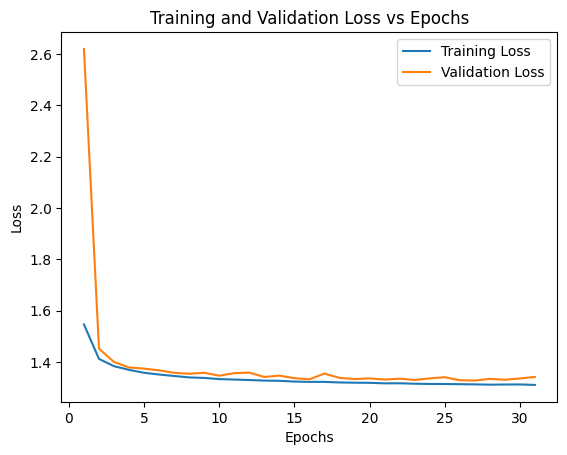

In [18]:
import matplotlib.pyplot as plt

tl = lc.tl
vl = lc.vl

min_length = min(len(tl), len(vl))
eps = list(range(1, min_length + 1))
tl = tl[:min_length]
vl = vl[:min_length]

plt.plot(eps, tl, label='Training Loss')
plt.plot(eps, vl, label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

